In [127]:
from universeg import universeg
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import torch
import math
from skimage import filters
from scipy import ndimage
import random
import torch
import nibabel as nb
import glob
from pathlib import Path
import pandas as pd

In [2]:
device = 'cpu'
print(device)
model = universeg(pretrained=True).to(device)

cpu


In [14]:
to_remove = []
ids_total = sorted(os.listdir("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask"))
ids_total.pop(0)
ids_total.pop(0)
to_remove = ['sub-73', 'sub-74', 'sub-75', 'sub-76', 'sub-77']
for item in to_remove:
    if item in ids_total:
        ids_total.remove(item)
ids_for_ref = ids_total[:47]
print(ids_for_ref)
print(len(ids_for_ref))

idx = random.sample(range(0, len(ids_for_ref)-1),3)
print(idx)

ids_for_test = ids_for_ref.copy()
# ids_for_test.pop(0)
# ids_for_test.pop(0)
for item in idx:
    to_remove.append(ids_for_ref[item])
print(to_remove)
for item in to_remove:
    if item in ids_for_test:
        ids_for_test.remove(item)
print(ids_for_test)
print(len(ids_for_test))

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37', 'sub-38', 'sub-39', 'sub-40', 'sub-41', 'sub-42', 'sub-43', 'sub-44', 'sub-45', 'sub-46', 'sub-47']
47
[39, 44, 23]
['sub-73', 'sub-74', 'sub-75', 'sub-76', 'sub-77', 'sub-40', 'sub-45', 'sub-24']
['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37', 'sub-38', 'sub-39', 'sub-41', 'sub-42', 'sub-43', 'sub-44', 'sub-46', '

In [81]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def dice_score(y_pred, y_true) -> float:
    # y_pred = y_pred.long()
    # y_true = y_true.long()
    
    # score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    score = np.sum((y_pred == 1) & (y_true == 1))*2.0 / (np.sum(y_pred==1) + np.sum(y_true==1))
    # return score.item()
    # print(score)
    return score

In [17]:
support_images = []
support_labels = []
test_images = []
test_labels = []
# min = 12
min = 0
max = 20
# folder_loc = "/home/neuroimaging/Desktop/Sarvagya_work/segmentation_project/med2image/"
for i in (idx):
    print(i)
    print(ids_for_ref[i])
    sessions = sorted([ses for ses in os.listdir("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/"+ids_for_ref[i]) if "ses-" in ses])
    for ses in sessions:
        if not os.path.exists("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"+ids_for_ref[i]+"/"+ses):
            os.makedirs("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"+ids_for_ref[i]+"/"+ses)
        file_ground_truth = glob.glob("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/"+ids_for_ref[i]+"/"+ses+"/anat/*desc-crop_seg-manual_label-SC_mask.nii")
        file_sc_images = glob.glob("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/"+ids_for_ref[i]+"/"+ses+"/anat/*acq-lumbarMEGRE3D_desc-crop_T2starw.nii")
        
        img_ground_truth = nb.load(file_ground_truth[0])
        img_ground_truth_data = img_ground_truth.get_fdata()

        img_sc_images = nb.load(file_sc_images[0])
        img_sc_images_data = img_sc_images.get_fdata()

        # print(img_ground_truth_data.shape)
        # print(file_sc_images[0])
        
        # large_sc_images = sorted(os.listdir(folder_loc+i+'/'+img_folder))[min:max]
        for j in range(img_ground_truth_data.shape[2]):
            x = img_ground_truth_data[:,:,j]
            x = np.rot90(x)
            # x = x[0:96,0:96]
            # threshold = 100
            # x = 1.0 * (x > threshold)
            # print(x.shape)
        #     x_gray =rgb2gray(x)
            # normalized_x = (x-np.min(x))/(np.max(x)-np.min(x))
            x = torch.tensor(x.copy(), dtype=torch.float32)
            x = torch.reshape(x,(1,x.shape[0],x.shape[1]))
            support_labels.append(x)
        print("Support labels: ",len(support_labels))
        # large_sc_labels = sorted(os.listdir(folder_loc+i+'/'+label_folder))[min:max]
        for j in range(img_sc_images_data.shape[2]):
            x = img_sc_images_data[:,:,j]
            x = np.rot90(x)
            # x = x[0:96,0:96]
            normalized_x = (x-np.min(x))/(np.max(x)-np.min(x))
            normalized_x = torch.tensor(normalized_x, dtype=torch.float32)
            normalized_x = torch.reshape(normalized_x, (1,x.shape[0],x.shape[1]))
            support_images.append(normalized_x)
        print("Support images: ",len(support_images))

support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

39
sub-40
Support labels:  20
Support images:  20
44
sub-45
Support labels:  40
Support images:  40
23
sub-24
Support labels:  60
Support images:  60


In [18]:
support_images.shape

torch.Size([60, 1, 120, 120])

In [19]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

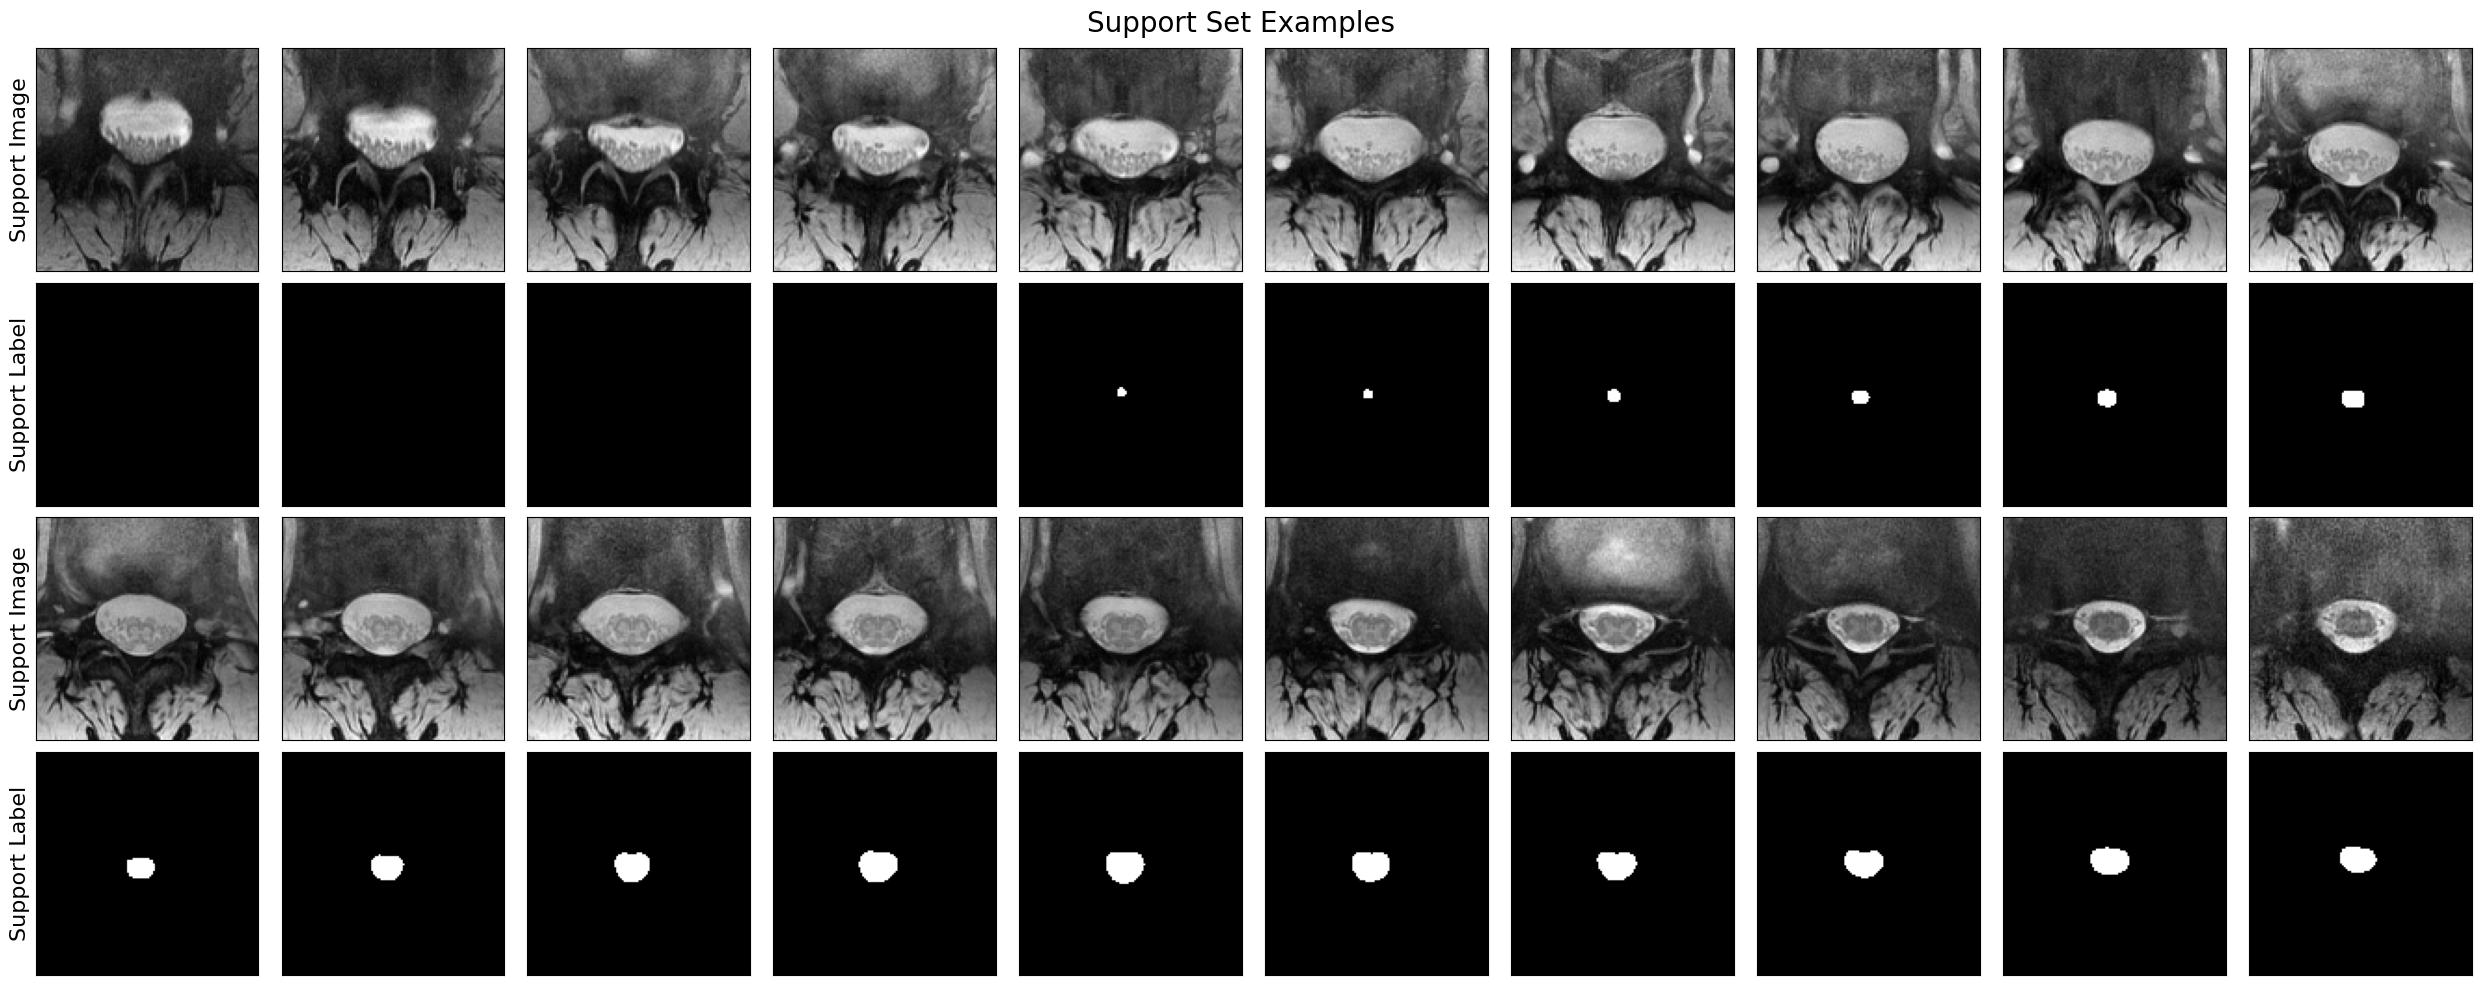

In [20]:
n_viz = 20
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

Here, two folders are created. One is size_97 that was for subjects wiuth image size of 97. But due to a mistake in the image saving location, the segmented results were saved in (../../GM_mask/segmented_images/) instead of (../../GM_mask/segmented_images/size_97). Lucily, no data weas lost since these folders were mepty from the beginning. The other subjects will be saved in the first location as intended. The results from the previous iteration are saved in (../../GM_mask/segmented_images/old_results)

In [21]:
# dice_score_inference = np.zeros((47,20))
img_infer = []
label_infer = []
pred_infer = []
count = 0
output_folder = "/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"
for sub in (ids_for_test):
    print(sub)
    sessions = sorted([ses for ses in os.listdir("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/"+sub) if "ses-" in ses])

    for ses in sessions:
        if not os.path.exists("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"+sub+"/"+ses):
            os.makedirs("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"+sub+"/"+ses)

        test_images = []
        test_labels = []

        file_ground_truth = glob.glob("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/"+sub+"/"+ses+"/anat/*desc-crop_seg-manual_label-SC_mask.nii")

        file_sc_images = glob.glob("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/"+sub+"/"+ses+"/anat/*acq-lumbarMEGRE3D_desc-crop_T2starw.nii")

        img_ground_truth = nb.load(file_ground_truth[0])
        img_ground_truth_data = img_ground_truth.get_fdata()

        img_sc_images = nb.load(file_sc_images[0])
        img_sc_images_data = img_sc_images.get_fdata()

        if img_sc_images_data.shape[0]!=120:
             
             pass
        
        else:
            for i in range(img_sc_images_data.shape[2]):
                x_gray = img_sc_images_data[:,:,i]
                x_gray = np.rot90(x_gray)
                # x_gray = x_gray[0:96, 0:96]
                # x_gray =rgb2gray(x)
                normalized_x_gray = (x_gray-np.min(x_gray))/(np.max(x_gray)-np.min(x_gray))
                normalized_x_gray = torch.tensor(normalized_x_gray, dtype=torch.float32)
                normalized_x_gray = torch.reshape(normalized_x_gray,(1,x_gray.shape[0],x_gray.shape[1]))
                test_images.append(normalized_x_gray)

            for i in range(img_ground_truth_data.shape[2]):
                x_gray = img_ground_truth_data[:,:,i]
                x_gray = np.rot90(x_gray)
                # x_gray = x_gray[0:96, 0:96]
                # x = rgb2gray(x)
                threshold = 100
                # x = 1.0 * (x_gray > threshold)
                # x = (x-np.min(x))/(np.max(x)-np.min(x))
                x_gray = torch.tensor(x_gray.copy(), dtype=torch.float32)
                x_gray = torch.reshape(x_gray, (1,x_gray.shape[0],x_gray.shape[1]))
                test_labels.append(x_gray)
            
            test_images = torch.stack(test_images).to(device)
            test_labels = torch.stack(test_labels).to(device)

            # idx = np.random.permutation(len(test_images))[0]
            for i in range(len(test_images)):
                image, label = test_images[i], test_labels[i]
                # print(image[None].shape)
                # print(support_images[None].shape)
                # print(support_labels[None].shape)
                image, label = image.to(device), label.to(device)

            # run inference
                logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
                pred = torch.sigmoid(logits)
                # print(pred.shape)


                # visualize
                # res = {'data': [image, label, pred, pred > 0.3]}
                # score_dice_hard = dice_score(pred>0.3, label)
                # score_dice_hard = format(score_dice_hard, '.2f')
                # dice_score_inference.append(score_dice_hard)
                # dice_score_inference[count, i] = score_dice_hard
                # titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard) dice score = ' + str(score_dice_hard)]
                # visualize_tensors(res, col_wrap=4, col_names=titles)
                # img_infer.append(image.cpu().detach().numpy().squeeze())
                # label_infer.append(label.cpu().detach().numpy().squeeze())
                # pred_infer.append(pred.cpu().detach().numpy().squeeze())
                # print(pred_out.cpu().detach().numpy().squeeze().shape)
                plt.imsave("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"+sub+"/"+ses+"/"+"pred_"+str(f"{i:03}")+".png", pred.cpu().detach().numpy().squeeze())

            # count+=1
# print(count)



sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
sub-17
sub-18
sub-19
sub-20
sub-21
sub-22
sub-23
sub-25
sub-26
sub-27
sub-28
sub-29
sub-30
sub-31
sub-32
sub-33
sub-34
sub-35
sub-36
sub-37
sub-38
sub-39
sub-41
sub-42
sub-43
sub-44
sub-46
sub-47


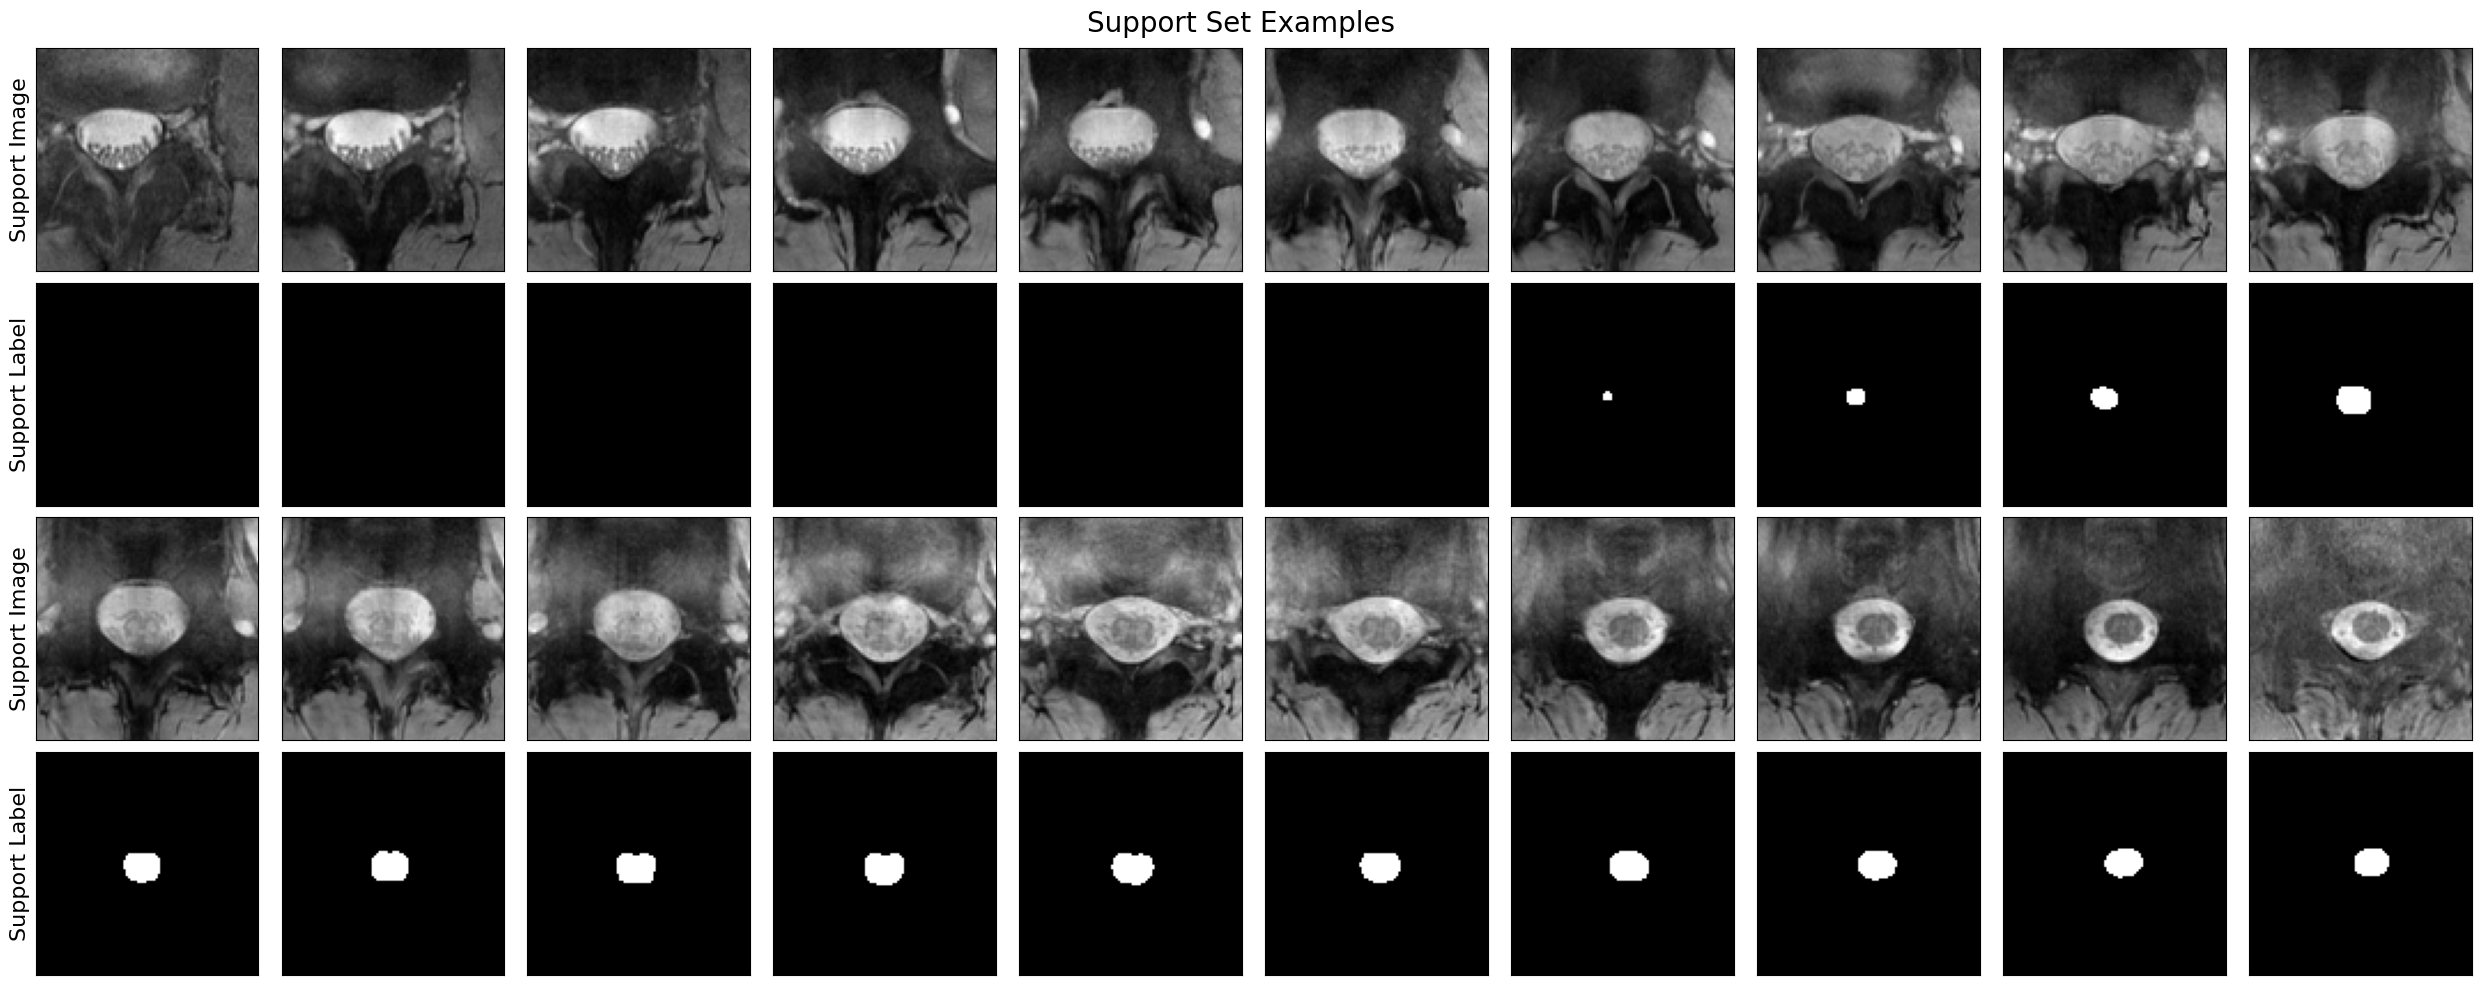

In [15]:
n_viz = 20
visualize_tensors({
    'Support Image': test_images[:n_viz],
    'Support Label': test_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

In [135]:
segmented_outputs = "/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"
original_segment = "/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/"
ids_total = sorted(os.listdir("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask"))
ids_total.pop(0)
ids_total.pop(0)
to_remove = ['sub-73', 'sub-74', 'sub-75', 'sub-76', 'sub-77']
for item in to_remove:
    if item in ids_total:
        ids_total.remove(item)
dice_score_mat_universeg = np.zeros((57,20))
count = 0
for sub in ids_total:
    print(sub)
    sessions = sorted([ses for ses in os.listdir("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"+sub) if "ses-" in ses])
    for ses in sessions:
        if len(os.listdir("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"+sub+"/"+ses)) == 0:
            pass
        else:
            imgs = sorted(os.listdir("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"+sub+"/"+ses))
            # print(len(imgs))
            file_ground_truth = glob.glob("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/"+sub+"/"+ses+"/anat/*desc-crop_seg-manual_label-SC_mask.nii")
            img_ground_truth = nb.load(file_ground_truth[0])
            img_ground_truth_data = img_ground_truth.get_fdata()
            if img_ground_truth_data.shape[0]!=97:
                pass
            else:
                for i in range(img_ground_truth_data.shape[2]):
                    orig_scan = img_ground_truth_data[:,:,i]
                    orig_scan = np.rot90(orig_scan)
                    orig_scan = orig_scan[0:96, 0:96]

                    print(imgs[i])
                    pred = plt.imread("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"+sub+"/"+ses+"/"+imgs[i])
                    pred_gray = rgb2gray(pred[:,:,0:3])
                    # print(np.unique(pred_gray*orig_scan))
                    temp_dice = dice_score(pred_gray > 0.3, orig_scan)
                    temp_dice = format(temp_dice, '.3f')
                    print(temp_dice)
                    dice_score_mat_universeg[count,i] = temp_dice
                count+=1
print(count)

sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
sub-17
sub-18
sub-19
sub-20
sub-21
sub-22
sub-23
sub-24
sub-25
sub-26
sub-27
sub-28
sub-29
sub-30
sub-31
sub-32
sub-33
sub-34
sub-35
sub-36
sub-37
sub-38
sub-39
sub-40
sub-41
sub-42
sub-43
sub-44
sub-45
sub-46
sub-47
sub-48
pred_000.png
0.000
pred_001.png
0.000
pred_002.png
0.000
pred_003.png
0.000
pred_004.png
0.000
pred_005.png
0.205
pred_006.png
0.167
pred_007.png
0.299
pred_008.png
0.401
pred_009.png
0.675
pred_010.png
0.659
pred_011.png
0.777
pred_012.png
0.908
pred_013.png
0.890
pred_014.png
0.909
pred_015.png
0.921
pred_016.png
0.931
pred_017.png
0.932
pred_018.png
0.935
pred_019.png
0.903
sub-49
pred_000.png
0.000
pred_001.png
0.000
pred_002.png
0.000
pred_003.png
0.000
pred_004.png
0.000
pred_005.png
0.089
pred_006.png
0.086
pred_007.png
0.330
pred_008.png
0.462
pred_009.png
0.463
pred_010.png
0.632
pred_011.png
0.670
pred_012.png
0.783
pred_013.png
0.895
pred_014.pn

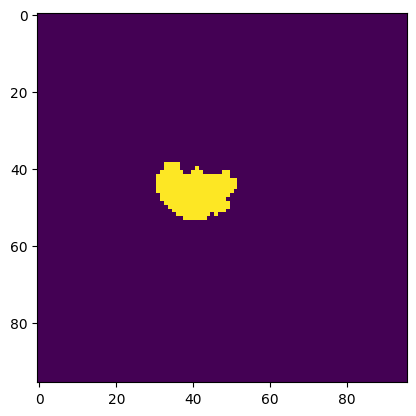

In [150]:
img = plt.imread("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/sub-48/ses-01/pred_000.png")
img_gray = rgb2gray(img[:,:,0:3])
# plt.imshow(img_gray)
img_gray_hard = img_gray > 0.3
plt.imshow(img_gray > 0.3)
# print(img)

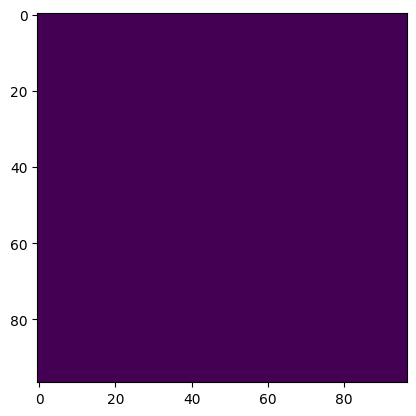

In [149]:
scan = nb.load("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/sub-48/ses-01/anat/sub-48_ses-01_acq-lumbarMEGRE3D_desc-crop_seg-manual_label-SC_mask.nii")
scan_data = scan.get_fdata()
x = np.rot90(scan_data[:,:,0])
x = x[0:96, 0:96]
plt.imshow(np.rot90(scan_data[:,:,0]))

np.int64(0)

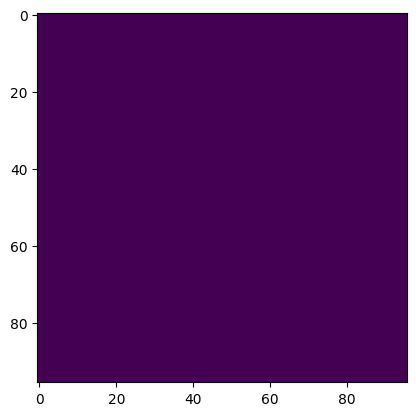

In [151]:
plt.imshow((img_gray_hard == 1) & (x == 1))
np.sum((img_gray_hard == 1) & (x == 1))

In [147]:
dice_score_mat_universeg

array([[0.   , 0.   , 0.   , ..., 0.932, 0.935, 0.903],
       [0.   , 0.   , 0.   , ..., 0.904, 0.88 , 0.909],
       [0.   , 0.   , 0.   , ..., 0.798, 0.854, 0.845],
       ...,
       [0.   , 0.   , 0.   , ..., 0.886, 0.856, 0.843],
       [0.   , 0.   , 0.   , ..., 0.896, 0.89 , 0.864],
       [0.   , 0.   , 0.   , ..., 0.864, 0.854, 0.84 ]])

In [148]:
df = pd.DataFrame(dice_score_mat_universeg)
df.to_csv("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/dice_score_size_96.csv", header=False, index=False)